# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import lightgbm as lgb

from datetime import datetime

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, StackingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import svm

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [5]:
def create_features(df):
    """
    与えられたデータフレームに対して特徴量エンジニアリングを行う関数。

    Args:
    df (DataFrame): 特徴量エンジニアリングを行うデータフレーム

    Returns:
    DataFrame: 新しい特徴量が追加されたデータフレーム
    """
    # キルとデスの比率
    df['killDeathRatio'] = df['blueKills'] / (df['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

    # キルとデスの差
    df['killDeathDiff'] = df['blueKills'] - df['blueDeaths']
    # 負の値を0で置き換え
    df['killDeathDiff'] = df['killDeathDiff'].clip(lower=0)

    # アシストの割合
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)

    # ヘラルドの討伐数
    df['blueHerald'] = df['blueEliteMonsters'] - df['blueDragons']
    # blueHerald列の負の値を0で置き換え
    df['blueHerald'] = df['blueHerald'].clip(lower=0)

    # エリートモンスターとドラゴンの比率
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    # エリートモンスターとヘラルドの比率
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)

    # ゴールドと経験値の対数変換
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])

    # ゴールドと経験値の相互作用
    df['goldXexperience'] = df['blueTotalGold'] * df['blueTotalExperience']

    # 初期キルの影響
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    
    # キル、デス、アシストの合計
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    # キル・デス・アシスト比率
    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    # 効率的なリソース利用
    df['goldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['experiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1

    # エリートモンスターの討伐効率
    df['eliteMonstersPerGold'] = df['blueEliteMonsters'] / df['blueTotalGold']
    df['eliteMonstersPerExperience'] = df['blueEliteMonsters'] / df['blueTotalExperience']

    # チームの総合力
    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']

    return df

- Apply data

In [6]:
train = create_features(train)
test = create_features(test)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gameId                      8000 non-null   int64  
 1   blueFirstBlood              8000 non-null   int64  
 2   blueKills                   8000 non-null   int64  
 3   blueDeaths                  8000 non-null   int64  
 4   blueAssists                 8000 non-null   int64  
 5   blueEliteMonsters           8000 non-null   int64  
 6   blueDragons                 8000 non-null   int64  
 7   blueTotalGold               8000 non-null   int64  
 8   blueTotalExperience         8000 non-null   int64  
 9   blueWins                    8000 non-null   int64  
 10  killDeathRatio              8000 non-null   float64
 11  killDeathDiff               8000 non-null   int64  
 12  assistRate                  8000 non-null   float64
 13  blueHerald                  8000 

# 特徴量の効き

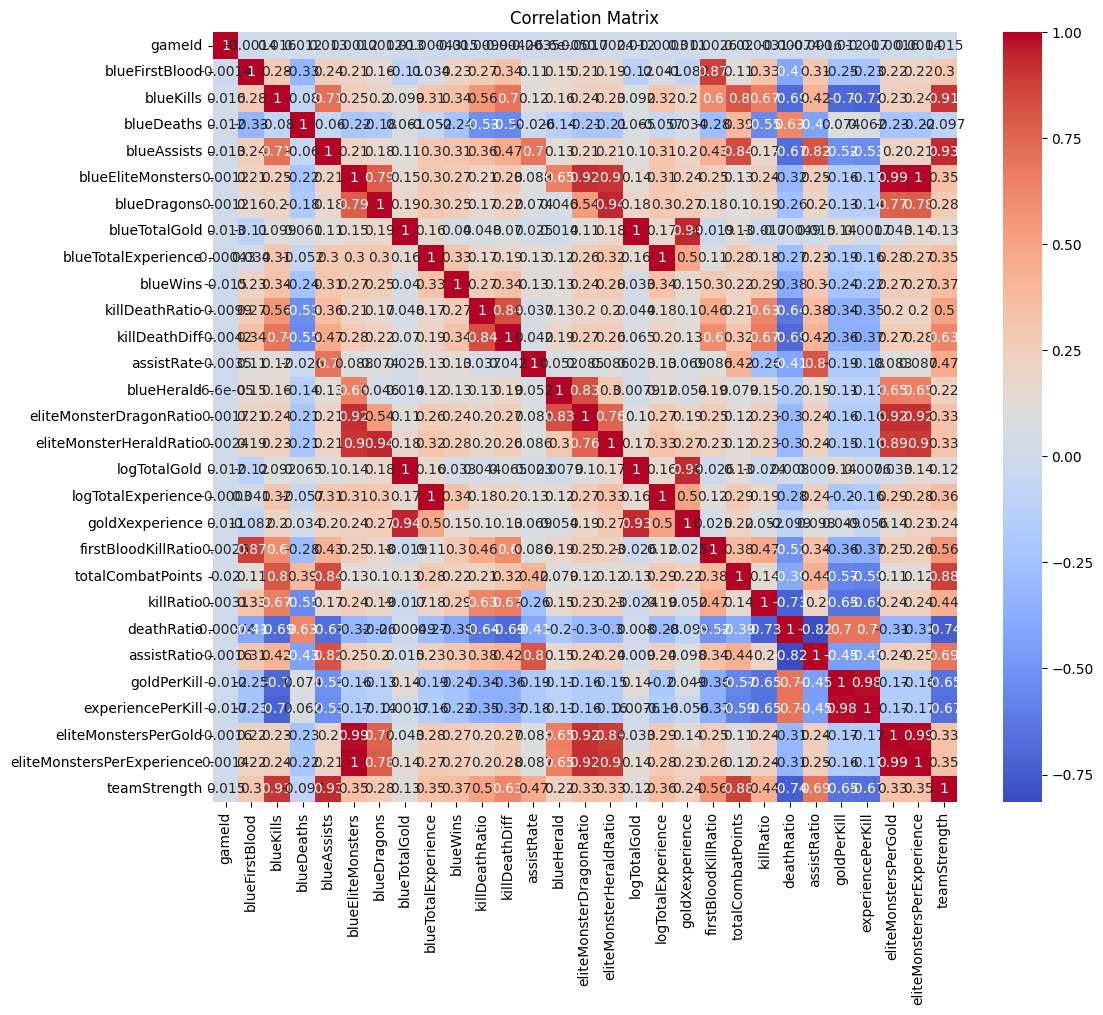

In [8]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- data

In [9]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)


"""
test_drop_gameId_temp = test.drop('gameId', axis=1)
# 特徴量の標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)  # 検証データも同じスケーラーを使用して標準化

# テストデータも同じスケーラーを使用して標準化
test_drop_gameId_scaled = scaler.transform(test_drop_gameId_temp)

# NumPy配列からPandasデータフレームに変換
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
test_drop_gameId = pd.DataFrame(test_drop_gameId_scaled, columns=test_drop_gameId_temp.columns)
"""


"\ntest_drop_gameId_temp = test.drop('gameId', axis=1)\n# 特徴量の標準化\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_val = scaler.transform(X_val)  # 検証データも同じスケーラーを使用して標準化\n\n# テストデータも同じスケーラーを使用して標準化\ntest_drop_gameId_scaled = scaler.transform(test_drop_gameId_temp)\n\n# NumPy配列からPandasデータフレームに変換\nX_train = pd.DataFrame(X_train, columns=X.columns)\nX_val = pd.DataFrame(X_val, columns=X.columns)\ntest_drop_gameId = pd.DataFrame(test_drop_gameId_scaled, columns=test_drop_gameId_temp.columns)\n"

In [10]:
X_train

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,killDeathRatio,killDeathDiff,...,firstBloodKillRatio,totalCombatPoints,killRatio,deathRatio,assistRatio,goldPerKill,experiencePerKill,eliteMonstersPerGold,eliteMonstersPerExperience,teamStrength
1001,1,11,3,8,1,1,18274,18472,2.750000,8,...,11,22,0.500000,0.136364,0.363636,1522.833333,1539.333333,0.000055,0.000054,20
7360,0,6,11,7,0,0,20619,17256,0.500000,0,...,0,24,0.250000,0.458333,0.291667,2945.571429,2465.142857,0.000000,0.000000,13
5234,1,6,3,5,1,0,16961,18201,1.500000,3,...,6,14,0.428571,0.214286,0.357143,2423.000000,2600.142857,0.000059,0.000055,12
7390,0,9,5,8,0,0,18117,18472,1.500000,4,...,0,22,0.409091,0.227273,0.363636,1811.700000,1847.200000,0.000000,0.000000,17
6841,1,9,4,9,0,0,14536,17256,1.800000,5,...,9,22,0.409091,0.181818,0.409091,1453.600000,1725.600000,0.000000,0.000000,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0,6,5,3,1,1,17409,17256,1.000000,1,...,0,14,0.428571,0.357143,0.214286,2487.000000,2465.142857,0.000057,0.000058,10
3264,0,5,10,4,1,1,20619,17256,0.454545,0,...,0,19,0.263158,0.526316,0.210526,3436.500000,2876.000000,0.000048,0.000058,10
1653,0,4,11,6,0,0,16544,18201,0.333333,0,...,0,21,0.190476,0.523810,0.285714,3308.800000,3640.200000,0.000000,0.000000,10
2607,0,4,3,3,1,1,18117,18491,1.000000,1,...,0,10,0.400000,0.300000,0.300000,3623.400000,3698.200000,0.000055,0.000054,8


In [11]:
X_val

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,killDeathRatio,killDeathDiff,...,firstBloodKillRatio,totalCombatPoints,killRatio,deathRatio,assistRatio,goldPerKill,experiencePerKill,eliteMonstersPerGold,eliteMonstersPerExperience,teamStrength
3069,1,5,5,4,0,0,14536,17119,0.833333,0,...,5,14,0.357143,0.357143,0.285714,2422.666667,2853.166667,0.000000,0.000000,9
1675,1,9,7,13,1,1,18274,18472,1.125000,2,...,9,29,0.310345,0.241379,0.448276,1827.400000,1847.200000,0.000055,0.000054,23
6385,0,3,6,2,0,0,17409,17256,0.428571,0,...,0,11,0.272727,0.545455,0.181818,4352.250000,4314.000000,0.000000,0.000000,5
543,0,5,4,8,1,1,18274,18472,1.000000,1,...,0,17,0.294118,0.235294,0.470588,3045.666667,3078.666667,0.000055,0.000054,14
3213,1,5,4,6,1,1,13519,18021,1.000000,1,...,5,15,0.333333,0.266667,0.400000,2253.166667,3003.500000,0.000074,0.000055,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7716,0,0,3,0,1,1,20619,17256,0.000000,0,...,0,3,0.000000,1.000000,0.000000,20619.000000,17256.000000,0.000048,0.000058,1
4766,0,6,3,8,0,0,18117,18472,1.500000,3,...,0,17,0.352941,0.176471,0.470588,2588.142857,2638.857143,0.000000,0.000000,14
4096,1,5,4,6,2,1,13519,18021,1.000000,1,...,5,15,0.333333,0.266667,0.400000,2253.166667,3003.500000,0.000148,0.000111,13
1595,1,10,1,14,1,0,18274,18491,5.000000,9,...,10,25,0.400000,0.040000,0.560000,1661.272727,1681.000000,0.000055,0.000054,25


- study

In [12]:
def predict(X_train, y_train, X_test, mode, X_val):
    preds = []  # バリデーションデータに対する予測結果を格納するリスト
    preds_val = []
    preds_test = []  # テストデータに対する予測結果を格納するリスト

    # クロスバリデーションで予測を実行
    kf = KFold(n_splits=4, shuffle=True, random_state=71)
    for tr_idx, va_idx in kf.split(X_train):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # モデルを構築
        if mode == 'LightGBM':
            params = {'bagging_fraction': 0.4600347572555584,
                      'bagging_freq': 5,
                      'boosting_type': 'gbdt',
                      'feature_fraction': 0.7,
                      'feature_pre_filter': False,
                      'lambda_l1': 0.004418000666138604,
                      'lambda_l2': 8.039538280454251e-06,
                      'min_child_samples': 20,
                      'num_leaves': 4,
                      'objective': 'binary',
                      'seed': 71,
                      'task': 'train',
                      'verbose': 0}
            lgb_train = lgb.Dataset(tr_x, tr_y)
            lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)
            # 早期停止コールバックを設定
            callbacks = [lgb.early_stopping(50)]
            model = lgb.train(params, lgb_train, num_boost_round=1000, callbacks=callbacks, valid_sets=lgb_eval)

        elif mode == 'RandomForest':
            model = RandomForestClassifier(random_state=123, n_estimators=9, criterion='gini', max_depth=25)
            model = model.fit(tr_x, tr_y)

        elif mode == 'SVM':
            model = svm.LinearSVC()
            model = model.fit(tr_x, tr_y)

        elif mode == 'LogisticRegression':
            model = LogisticRegression()
            model = model.fit(tr_x, tr_y)

        elif mode == 'CatBoost':
            params = {
                # CatBoostのパラメータ設定
            }
            model = CatBoostClassifier(**params)
            model = model.fit(tr_x, tr_y)

        elif mode == 'XGBoost':
            params = {
                # XGBoostのパラメータ設定
            }
            model = xgb.XGBClassifier(**params)
            model = model.fit(tr_x, tr_y)

        # バリデーションデータに対する予測
        pred = model.predict(va_x)
        preds.append(pred)

        pred_val = model.predict(X_val)
        preds_val.append(pred_val)

        # テストデータに対する予測
        pred_test = model.predict(X_test)
        preds_test.append(pred_test)

    # バリデーションデータに対する予測結果を連結、元の順序に戻す
    preds = np.concatenate(preds, axis=0)

        # バリデーションデータに対する予測結果を連結、元の順序に戻す
    preds_val = np.concatenate(preds_val, axis=0)

    # テストデータに対する平均予測値を取得
    preds_test = np.mean(preds_test, axis=0)

    return preds, preds_val, preds_test

- 学習

In [13]:
# 異なるモデルのベースモデルを定義
base_models = [
    ('LightGBM', lgb.LGBMClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=123, n_estimators=9, criterion='gini', max_depth=25)),
    ('LogisticRegression', LogisticRegression()),
    ('XGBoost', XGBClassifier()),
    ('CatBoost', CatBoostClassifier())
]

# スタッキングモデルを定義（ここではロジスティック回帰を使用）
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
# stacking_model = StackingClassifier(estimators=base_models, final_estimator=RandomForestClassifier(random_state=123))

# ベースモデルのトレーニングと予測
for model_name, model in base_models:
    preds_train, preds_val, preds_test = predict(X_train, y_train, test_drop_gameId, model_name, X_val)  # テストデータを使って予測
    # トレーニングデータの予測結果を特徴として追加
    X_train[model_name] = preds_train
    X_val[model_name] = preds_val
    test_drop_gameId[model_name] = preds_test  # テストデータの特徴量として追加

# スタッキングモデルのトレーニング
stacking_model.fit(X_train, y_train)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.456079
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 0.454729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.474172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.46824


ValueError: Length of values (6400) does not match length of index (1600)

- y_val accuracy確認

In [ ]:
# X_valデータでモデルの精度を評価
y_val_pred = stacking_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.7925


- testにy_test_pred結合

In [ ]:
stacking_test_preds = stacking_model.predict(test_drop_gameId)

In [ ]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_submit_cv_stacking_val{val_accuracy:.4f}.csv'

In [ ]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': stacking_test_preds
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [ ]:
check = pd.read_csv(output)

In [ ]:
check

,9,1
0,15,1
1,18,0
2,23,0
3,31,1
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
